## **MAIS 202 Assignment 4**

Final code submission for max digit recognition. To run the code, import kaggle api key to access data. Everything else should be handled by the code.

---

Note that not all of this code is our own. Some of it is sourced from: https://github.com/nikhilpodila/Modified-MNIST


In [ ]:
# Install kaggle
! pip install -q kaggle

# Upload kaggle api key
from google.colab import files
files.upload()

# Change file permissions
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download data from kaggle api
! kaggle competitions download --force -c mais-202-fall-2020-kaggle-competition
! unzip train_x.npy.zip
! unzip test_x.npy.zip

In [2]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
import h5py
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, TimeDistributed, LSTM
from keras.layers import Conv2D, MaxPooling2D, Activation, MaxPool2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical,normalize
from keras import backend as K
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

import datetime

In [3]:
# Load data
train_images = np.load("train_x.npy")
test_images = np.load("test_x.npy") 
thresh = 0.99  # An arbitrary number that worked

thresh = 0.99
for i in range(len(train_images)):
  image = train_images[i]/255
  binary = image > thresh
  train_images[i] = binary.astype(int)

thresh = 0.99
for i in range(len(test_images)):
  image = test_images[i]/255
  binary = image > thresh
  test_images[i] = binary.astype(int)

train_y = pd.read_csv("train_y.csv")["Label"]

def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()

## Preprocessing

In [4]:
# One hot encoding
train_y = to_categorical(train_y)

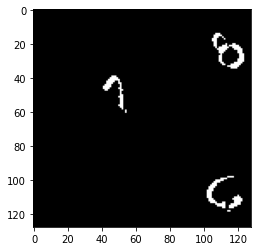

In [5]:
plt.imshow(train_images[5], cmap='gray')

In [6]:
# Reshape train images to 4D
train_images = train_images.reshape(train_images.shape[0],128,128,1)
test_images = test_images.reshape(test_images.shape[0],128,128,1)

In [7]:
# Data splitting

X_train, X_test, y_train, y_test = train_test_split(train_images, train_y, 
                                                    test_size=0.2, random_state=7)


In [8]:
# Data augmentation
batch_size = 200

datagen = ImageDataGenerator(
    # rescale = 1. / 255,
    rotation_range = 20,
    width_shift_range=0.1,
    shear_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2,
    # validation_split=0.1
)

datagen.fit(X_train)

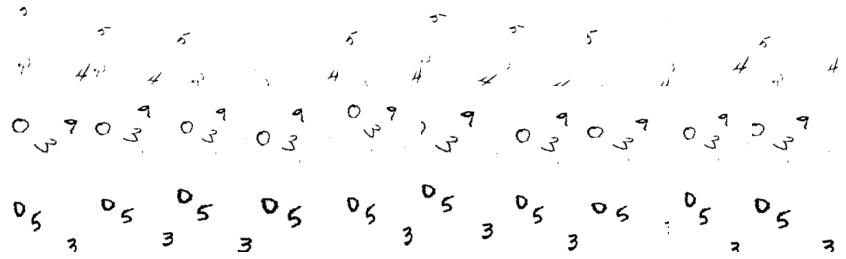

In [9]:
# Visualize data augmentation
X_train3 = X_train[9,].reshape((1,128,128,1))
Y_train3 = y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((128,128)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[2,].reshape((1,128,128,1))
    if i==19: X_train3 = X_train[10,].reshape((1,128,128,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [10]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.00001)

## Defining CNN Models
Below are three models: baseline CNN, modified VGG, and VGG16. We only had the time to train the modified VGG and VGG16.

In [11]:
# Baseline CNN model
def CNN(input_shape):

  # One layer CNN
  nets = 3
  
  # Model creation
  model = tf.keras.models.Sequential()

  # Model layers
  model.add(Conv2D(16,kernel_size=5,padding='same',activation='relu',input_shape=input_shape))
  model.add(MaxPool2D())
  model.add(Conv2D(32,kernel_size=5,padding='same',activation='relu'))
  model.add(MaxPool2D())
  model.add(Conv2D(256,kernel_size=5,padding='same',activation='relu'))
  model.add(MaxPool2D(padding='same'))
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

# Checkpointing
filepath="weights-improvement-trial_gen-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [12]:
# VGG16 model

def VGG(input_shape, opt = SGD(lr=0.01, momentum=0.9)):

  model = tf.keras.models.Sequential()

  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(units=1024,activation="relu"))
  model.add(Dense(units=1024,activation="relu"))
  model.add(Dense(units=10, activation="softmax"))

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [13]:
# Modified VGG model

def VGG_modified(input_shape, opt = optimizers.Adam(learning_rate=1e-4)):
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape,
                            data_format="channels_last"))
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    #sgd=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Checkpointing
filepath="weights-improvement-trial-randomstate_7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
# Metrics to be updated
class DisplayMetrics(Callback):
    def __init__(self, filename):
        self.filename = filename
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        with open(self.filename, "a") as f:
            for k,v in logs.items():
                f.write(str(k)+","+str(v)+",")
                pass
            f.write("\n")
            pass
        pass
    pass
pass

callbacks_list += [DisplayMetrics("logging_doctrialstate_7.csv")]

## Model training

In [15]:
model1 = VGG((128,128,1))

logdir = os.path.join("./tensorboard_trial/log_20191110_load1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list += [tensorboard_callback]

history1 = model1.fit(datagen.flow(X_train, y_train, batch_size=200),
                              validation_data=(X_test, y_test),
                              epochs = 85, callbacks=callbacks_list )

Epoch 1/85
  1/160 [..............................] - ETA: 0s - loss: 2.7181 - accuracy: 0.1100WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
160/160 [==============================] - ETA: 0s - loss: 1.9458 - accuracy: 0.2545WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0029s vs `on_test_batch_end` time: 0.0197s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.26600, saving model to weights-improvement-trial-randomstate_7.hdf5
160/160 [==============================] - 73s 458ms/step - loss: 1.9458 - accuracy: 0.2545 - val_loss: 1.9503 - val_accuracy: 0.2660
Epoch 2/85
160/160 [==============================] - ETA: 0s - loss: 1.7385 - accuracy: 0.3534
Epoch 00002: val_accu

In [16]:
test_pred = model1.predict(test_images)

In [ ]:
list_pred = []
for i in range(test_pred.shape[0]):
  list_pred.append(np.where(test_pred[i] == max(test_pred[i]))[0])


submission = pd.DataFrame(list_pred, columns=['Label'])
  

[1.3236054e-04 9.7438489e-04 1.8926956e-05 3.0002404e-02 1.2301398e-04
 9.6448672e-01 2.3344620e-03 6.3573272e-04 1.3063398e-04 1.1613809e-03]
(10000, 10)


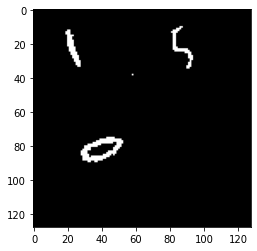

In [21]:
plt.imshow(test_images[5].reshape(128,128), cmap='gray')
submission.to_csv("submission.csv", index_label='ID', columns=['Label'])

print(test_pred[5])
print(test_pred.shape)

In [23]:
! kaggle competitions submit -c mais-202-fall-2020-kaggle-competition -f submission.csv -m "Message"

100% 67.3k/67.3k [00:07<00:00, 8.74kB/s]
Successfully submitted to MAIS 202 Fall 2020 - Kaggle Competition